In [1]:
import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#path to downloaded darknet and ken burns!
%cd ..

/home/mariia/Desktop/google


In [3]:
%cd darknet
from darknet import performDetect
#%cd ..

/home/mariia/Desktop/google/darknet


In [4]:
#exec(open('darknet.py', 'r').read())
imagePath = '../painting3.jpg'

In [5]:
from ctypes import *

class BOX():
    def __init__(self, x, y, w, h):
        self.x = x
        self.y = y
        self.h = h
        self.w = w
    def __repr__(self):
        return "[x : %f, y : %f, w : %f, h : %f]" %  (self.x, self.y, self.w, self.h)
    
    def __add__(self, box):
        res = BOX(
            self.x + box.x,
            self.y + box.y,
            self.w + box.w,#(self.x)*k_w,
            self.h + box.h,#(self.x)*k_h,
            #self.h + (box.y)*k_h,
            )
        return res

    def __sub__(self, box):
        res = BOX(
            self.x - box.x,
            self.y - box.y,
            self.w - box.w,# (-box.x)*k_w,
            self.h - box.h,# (-box.x)*k_h,
            #box.h + (self.y - 2*box.y)*k_h,

            )
        return res
        
    def __mul__(self, a):
        #print(a)
        res = BOX(a*self.x, a*self.y, a*self.h, a*self.w)
        return res
    
    def dist(self, a):
        delta_w = (self.x + self.w/2 - a.x  - a.w/2)
        delta_h = (self.y + self.h/2 - a.y  - a.h/2)
        return np.sqrt(delta_w**2+delta_h**2)
        
    def intersect(self, box):
        c1 = max(box.x, self.x)
        c2 = min(box.x+box.w, self.x+self.w)
        if c1 > c2:
            return -1
        d1 = max(box.y, self.y)
        d2 = min(box.y+box.h, self.y+self.h)
        if d1 > d2:
            return -1
        
        return (c2-c1)*(d2-d1)
    
    def getSurface(self):
        return self.h*self.w
    
    def IoU(self,box):
        return self.intersect(box)/(self.getSurface()+box.getSurface())
        
        
def interpolate(p0, p1, p2, p3, t):
    a = p0*(-0.5)+p1*1.5+p2*(-1.5)+p3*0.5
    b = p0+p1*(-2.5)+p2*2.0+p3*(-0.5)
    c = p0*(-0.5)+p2*0.5
    d = p1
    return d + c*t + b*t*t + a*t*t*t

    
class DETECTION():
    def __init__(self, nclass, confidence, bbox, depth=-1):
        self.nclass = nclass
        self.confidence = confidence
        self.bbox = BOX(bbox[0], bbox[1], bbox[2], bbox[3])
        
        self.depth = depth
        
        self.score=-1
        self.area = -1
        self.final_box = BOX(bbox[0], bbox[1], bbox[2], bbox[3])
        
    def __repr__(self):
        return "nclass : %s,\nconfidence : %f,\nbbox :%s,\ndepth : %f\n\n" %  (str(self.nclass), self.confidence, self.bbox, self.depth)
    def __str__(self):
        return "nclass : %s,\nconfidence : %f,\nbbox :%s,\ndepth : %f\n\n" %  (str(self.nclass), self.confidence, self.bbox, self.depth)

def resToDetections(res, depthMap):
    n = len(res)
    detections = []
    for i in range(n):        
        detection = DETECTION(res[i][0], res[i][1], res[i][2])
        depth = np.mean(cropImage(depthMap, detection.bbox))
        detection.depth = depth
        detections.append(detection)
    return detections

def cropImage(image, b):
    W, H, = image.shape[0], image.shape[1]
    x = b.x - b.w/2
    y = b.y - b.h/2
    return image[int(y):int(y+b.h), int(x):int(x+b.w)]

def linearInterpolation(box1, box2, delta=5):
    pass
    
def create_gif_full(gif,image,box1, box2, nb_interp, delta_x=None):
    #assert box1.h == box2.h
    #assert box1.w == box2.w
    
    w = 400#int(max(box1.w, box2.w))
    h = 400#int(max(box2.h, box1.h))
    frames = []
    x, y = 0, 0
    delta = (box2 - box1)*(1.0/(nb_interp-1))
    if delta_x is not None:
        nb_interp = (int)(np.sqrt(np.abs(box2.x**2 + box2.y**2 - (box1.x**2 + box1.y**2)))/delta_x)
        print(nb_interp)
        delta = (box2 - box1)*(1.0/(nb_interp-1))
    #print(delta)
    cur_box = box1#.copy()
    for i in range(nb_interp):
        #print(i)
        new_frame = PIL.Image.new('RGB', (w, h), 'white')
        #PIL.Image.fromarray(image, 'RGB').resize((w,h),PIL.Image.ANTIALIAS)
        #print()
        cur_box = box1 + delta*i#cur_box + delta
        im = PIL.Image.fromarray(cropImage(image, cur_box)).resize((w,h),PIL.Image.ANTIALIAS)
        new_frame.paste(im, (0, 0))
        #new_frame = PIL.Image.fromarray(get_image(i,g_all), 'RGB')
        frames.append(new_frame)
    
    return frames

def linear_step(x):
    return x

def create_gif_full_cubic(image,box0, box1, box2, box3, nb_interp, delta_x = None, step_function=linear_step):
    #assert box1.h == box2.h
    #assert box1.w == box2.w
    
    w = 400#int(max(box1.w, box2.w))
    h = 400#int(max(box2.h, box1.h))
    frames = []
    x, y = 0, 0

    #print(delta)
    cur_box = box1#.copy()
    for i in range(nb_interp):
        #print(i)
        new_frame = PIL.Image.new('RGB', (w, h), 'white')
        #PIL.Image.fromarray(image, 'RGB').resize((w,h),PIL.Image.ANTIALIAS)
        #print()
        cur_box = interpolate(box0, box1, box2, box3, step_function(i/(nb_interp)))#cur_box + delta
        im = PIL.Image.fromarray(cropImage(image, cur_box)).resize((w,h),PIL.Image.ANTIALIAS)
        new_frame.paste(im, (0, 0))
        #new_frame = PIL.Image.fromarray(get_image(i,g_all), 'RGB')
        frames.append(new_frame)
    return frames



def putSquares(image_input,box1, box2, nb_interp, confidence1=1.0, confidence2=1.0):
    from skimage import io, draw
    image = image_input.copy()
    w = int(max(box1.w, box2.w))
    h = int(max(box2.h, box1.h))
    frames = []
    shape = image.shape
    x, y = 0, 0
    delta = (box2 - box1)*(1.0/(nb_interp-1))
    #print(box1)
    #print(box2)
    cur_box = box1
    for i in range(nb_interp):
                #cur_box = cur_box + delta
                cur_box = box1 + delta*i
                #print(cur_box)
                confidence = confidence1 + (confidence2 - confidence1)*i*(1.0/(nb_interp-1))
                boundingBox = [
                    [cur_box.x - cur_box.w//2, cur_box.y - cur_box.h//2],
                    [cur_box.x - cur_box.w//2,  cur_box.y + cur_box.h//2],
                    [cur_box.x + cur_box.w//2, cur_box.y + cur_box.h//2],
                    [cur_box.x + cur_box.w//2, cur_box.y - cur_box.h//2]
                ]
                # Wiggle it around to make a 3px border
                rr, cc = draw.polygon_perimeter([x[1] for x in boundingBox], [x[0] for x in boundingBox], shape= shape)
                rr2, cc2 = draw.polygon_perimeter([x[1] + 1 for x in boundingBox], [x[0] for x in boundingBox], shape= shape)
                rr3, cc3 = draw.polygon_perimeter([x[1] - 1 for x in boundingBox], [x[0] for x in boundingBox], shape= shape)
                rr4, cc4 = draw.polygon_perimeter([x[1] for x in boundingBox], [x[0] + 1 for x in boundingBox], shape= shape)
                rr5, cc5 = draw.polygon_perimeter([x[1] for x in boundingBox], [x[0] - 1 for x in boundingBox], shape= shape)
                boxColor = (int(255 * (1 - (confidence ** 2))), int(255 * (confidence ** 2)), 0)
                draw.set_color(image, (rr, cc), boxColor, alpha= 0.8)
                draw.set_color(image, (rr2, cc2), boxColor, alpha= 0.8)
                draw.set_color(image, (rr3, cc3), boxColor, alpha= 0.8)
                draw.set_color(image, (rr4, cc4), boxColor, alpha= 0.8)
                draw.set_color(image, (rr5, cc5), boxColor, alpha= 0.8)
    return image#PIL.Image.fromarray(image)


#

In [6]:
a = BOX(3,3,5,5)#8 9 ... 5 5
b=BOX(4,4, 1, 1)
print(a+b)
print(a+b*2-b)
print(a.dist(b))
print(a.intersect(b))
print(a.IoU(b))

[x : 7.000000, y : 7.000000, w : 6.000000, h : 6.000000]
[x : 7.000000, y : 7.000000, w : 6.000000, h : 6.000000]
1.4142135623730951
1
0.038461538461538464


In [7]:
def shortestPath(detections):
    for detection in detections:
        detection.d = detection.final_box.dist(detections[0].final_box)
        detection.next = detections[0]
        detection.next_d = 100000000000
        detection.visited = 0
        detection.next_n = -1
    k = 0
    path = [detections[0]]
    detection = detections[0]
    visited = [0]*len(detections)
    detections[0].visited = 1
    while (k < len(detections)-1):
        #print(detection.next_d)
        
        for j, detection2 in enumerate(detections):
            #print(j)
            if detection == detection2:
                continue
            cur_dist = detection2.final_box.dist(detection.final_box)+detection.d
            #print(detection.d)
            
            #print(detection2.d)
            if (cur_dist <= detection.next_d) and (detection2.visited == 0):
                #print("if")
                detection.next_d = cur_dist
                detection.next = detection2
                detection.next_n = j
                #print(detection.next_n)
        #print(detection.next_n)
        if detection.next.visited == 0:
            #print("if2")
                
            path.append(detection.next)
            detection.visited = 1
            #print(detection.next)
            #print(detection.next_n)
            detection = detection.next
            

            k = k + 1
    return path
        
             
    

In [8]:
res = performDetect(imagePath=imagePath,showImage=False)

In [9]:
res

[('person',
  0.8640400171279907,
  (508.5387268066406, 1432.34814453125, 868.0339965820312, 395.3409118652344)),
 ('person',
  0.8146237134933472,
  (1491.6124267578125,
   661.7172241210938,
   217.81915283203125,
   611.493896484375)),
 ('person',
  0.7552170753479004,
  (1047.0283203125, 470.00567626953125, 119.3494644165039, 439.430908203125)),
 ('person',
  0.7243953943252563,
  (989.0518798828125,
   1189.222900390625,
   258.2749328613281,
   576.8955688476562)),
 ('umbrella',
  0.7230762243270874,
  (916.2295532226562,
   590.5154418945312,
   247.50875854492188,
   84.22184753417969)),
 ('person',
  0.7131383419036865,
  (1200.3336181640625,
   403.1765441894531,
   120.78224182128906,
   290.3011169433594)),
 ('person',
  0.6073036193847656,
  (529.1043701171875,
   1167.2708740234375,
   437.6917419433594,
   442.1475830078125)),
 ('person',
  0.5727249979972839,
  (1793.92529296875,
   494.67242431640625,
   104.46603393554688,
   150.26951599121094)),
 ('person',
  0.5479

In [10]:
import torch
import torchvision
%cd ../3d-ken-burns

assert(int(str('').join(torch.__version__.split('.')[0:3])) >= 120) # requires at least pytorch version 1.2.0

torch.set_grad_enabled(False) # make sure to not compute gradients for computational performance

torch.backends.cudnn.enabled = True # make sure to use cudnn for computational performance

import base64
import cupy
import cv2
import flask
import getopt
import gevent
import gevent.pywsgi
import h5py
import io
import math
import moviepy
import moviepy.editor
import numpy
import os
import random
import re
import scipy
import scipy.io
import shutil
import sys
import tempfile
import time
import urllib
import zipfile

import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_torch_image(x0, show=True, save=False, save_address=''):
        image=x0
        #image = (x0.clamp(-1, 1) + 1) / 2.0
        image = image.detach().squeeze(0).cpu().permute(1, 2, 0).numpy()
        image = np.uint8(image*255)  
        img = PIL.Image.fromarray(image, 'RGB')
        if show:
            plt.figure(figsize=(15, 6))
            plt.imshow(np.asarray(img))
            plt.show()
        if save:
            img.save(save_address)
        return image
            
            
def show_torch_gray_image(x0, show=True, save=False, save_address=''):
        n = x0.shape[2]
        m = x0.shape[3]
        image = (x0.clamp(-1, 1) + 1) / 2.0
        image = image.detach().squeeze(0).cpu().numpy().reshape(n,m)
        image = np.uint8(image*255)  
        img = PIL.Image.fromarray(image, 'L')
        if show:
            plt.figure(figsize=(15, 6))
            plt.imshow(np.asarray(img))
            plt.show()
        if save:
            img.save(save_address)
            %cd ../3d-ken-burns/
#exec(open('./common.py', 'r').read())

exec(open('./models/disparity-estimation.py', 'r').read())
exec(open('./models/disparity-adjustment.py', 'r').read())
exec(open('./models/disparity-refinement.py', 'r').read())
exec(open('./models/pointcloud-inpainting.py', 'r').read())
def estimDepth(imagePath):
    numpyImage = np.array(PIL.Image.open(imagePath))

    dblFocal = max(numpyImage.shape[0], numpyImage.shape[1]) / 2.0
    dblBaseline = 40.0

    tensorImage = torch.FloatTensor(numpyImage.transpose(2, 0, 1)).unsqueeze(0).cuda() / 255.0
    show_torch_image(tensorImage)
    tensorDisparity = disparity_estimation(tensorImage)
    tensorDisparity = disparity_refinement(torch.nn.functional.interpolate(input=tensorImage, size=(tensorDisparity.size(2) * 4, tensorDisparity.size(3) * 4), mode='bilinear', align_corners=False), tensorDisparity)
    tensorDisparity = torch.nn.functional.interpolate(input=tensorDisparity, size=(tensorImage.size(2), tensorImage.size(3)), mode='bilinear', align_corners=False) * (max(tensorImage.size(2), tensorImage.size(3)) / 256.0)
    tensorDepth = (dblFocal * dblBaseline) / (tensorDisparity + 0.0000001)
    #show_torch_gray_image(tensorDepth/2000)
    #show_torch_gray_image(tensorDisparity/(dblBaseline*20.0))
    numpyDisparity = tensorDisparity[0, 0, :, :].cpu().numpy()
    numpyDepth = tensorDepth[0, 0, :, :].cpu().numpy()
    return numpyDepth



/home/mariia/Desktop/google/3d-ken-burns


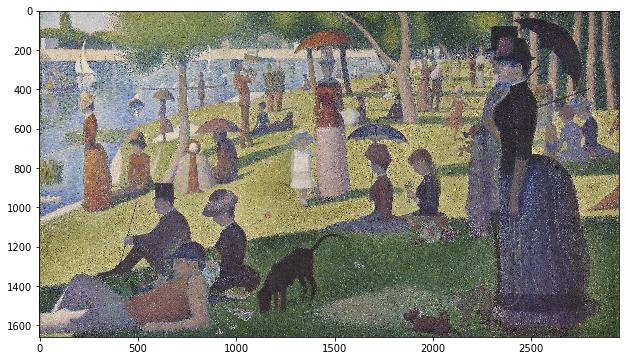

In [11]:
depthMap = estimDepth(imagePath)

In [12]:
detections = resToDetections(res, depthMap)

In [13]:
detections

[nclass : person,
 confidence : 0.864040,
 bbox :[x : 508.538727, y : 1432.348145, w : 868.033997, h : 395.340912],
 depth : 713.874756
 , nclass : person,
 confidence : 0.814624,
 bbox :[x : 1491.612427, y : 661.717224, w : 217.819153, h : 611.493896],
 depth : 969.046082
 , nclass : person,
 confidence : 0.755217,
 bbox :[x : 1047.028320, y : 470.005676, w : 119.349464, h : 439.430908],
 depth : 946.492859
 , nclass : person,
 confidence : 0.724395,
 bbox :[x : 989.051880, y : 1189.222900, w : 258.274933, h : 576.895569],
 depth : 836.857666
 , nclass : umbrella,
 confidence : 0.723076,
 bbox :[x : 916.229553, y : 590.515442, w : 247.508759, h : 84.221848],
 depth : 936.260681
 , nclass : person,
 confidence : 0.713138,
 bbox :[x : 1200.333618, y : 403.176544, w : 120.782242, h : 290.301117],
 depth : 963.778381
 , nclass : person,
 confidence : 0.607304,
 bbox :[x : 529.104370, y : 1167.270874, w : 437.691742, h : 442.147583],
 depth : 812.448242
 , nclass : person,
 confidence : 0.

In [14]:
detections = shortestPath(detections)

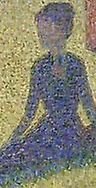

In [15]:
i = 7
image = np.array(PIL.Image.open(imagePath))
PIL.Image.fromarray(cropImage(image, detections[i].final_box))

In [16]:
from sklearn.cluster import DBSCAN

def scaleDepth(detections):
    max_detection = (max(detections, key=lambda p : p.depth)).depth
    min_detection = (min(detections, key=lambda p : p.depth)).depth
    for i in range(len(detections)):
        detection = detections[i]
        detection.depth = (detection.depth-min_detection)/(max_detection-min_detection)
        
def scaleScore(detections):
    for i in range(len(detections)):
        detection = detections[i]
        detection.score = (detection.depth*detection.confidence)
    detections.sort(key = lambda x : x.score)
    
def cleanRepeats(detections):
    print('Cleaning overlapping boxes...')
    n = len(detections)
    i, j = 0, 0
    while (i<len(detections)):
        while (j <len(detections)):
            #print(detections[i].bbox.IoU(detections[j].bbox))
            if (i != j) and (detections[i].bbox.IoU(detections[j].bbox) > 0.07):
                if detections[i].bbox.h*detections[i].bbox.w > detections[j].bbox.h * detections[j].bbox.w:
                    del detections[j]
                else:
                    del detections[i]
            else:
                 j = j + 1
        i = i + 1
        j = 0
    print('Number of boxes reduced from %d to %d' % (n, len(detections)))
    print(len(detections))
    return detections
    
def scaleAreaCLusters(detections, shape):
    areas = []

    for i in range(len(detections)):
        detection = detections[i]
        detection.area = (detection.bbox.w*detection.bbox.h)
        areas.append(detection.area)
        detection.h_mean = 0
        detection.w_mean = 0
        
    areas = np.array(areas).reshape(-1,1)
    clustering = DBSCAN(eps=0.002*max(shape)**2, min_samples=2).fit(areas)
    labels = clustering.labels_
    
    unique_labels = np.unique(labels)
    #for i in range()
    d = {unique_labels[i]:i for i in range(len(unique_labels))}
    
    
    h_means = [0]*len(unique_labels)
    w_means = [0]*len(unique_labels)
    cardinality = [np.sum(labels==i) for i in unique_labels]
    
    
    
    for i in range(len(detections)):
        detection = detections[i]
        detection.label = labels[i]
        index_in_unique = d[detections[i].label]
        #h_means[detection.label] += detection.bbox.h
        #w_means[detection.label] += detection.bbox.w
        h_means[index_in_unique] = max(detection.bbox.h, h_means[index_in_unique])
        w_means[index_in_unique] = max(detection.bbox.w, w_means[index_in_unique])
        
        
    #for i in range(len(unique_labels)):
    #    h_means[i] /= cardinality[i]
    #   w_means[i] /= cardinality[i]  

        
    for i in range(len(detections)):
        index_in_unique = d[detections[i].label]
        detections[i].final_box = BOX(detections[i].bbox.x, detections[i].bbox.y, w_means[index_in_unique], h_means[index_in_unique])
        #print(detections[i].final_box)
    return detections, h_means, w_means, labels
    
def scaleAreaCLustersWithCustomShape(detections, shape, k):
    print('Scaling clusters according to the scores forming custom.shape...')
    areas = []
    for i in range(len(detections)):
        detection = detections[i]
        detection.area = (detection.bbox.w*detection.bbox.h)
        areas.append(detection.area)
        detection.h_mean = 0
        detection.w_mean = 0
        
    areas = np.array(areas).reshape(-1,1)
    #clustering = DBSCAN(eps=0.002*max(shape)**2, min_samples=2).fit(areas)
    labels = list(range(len(detections)))#clustering.labels_
    
    unique_labels = np.unique(labels)
    #for i in range()
    d = {unique_labels[i]:i for i in range(len(unique_labels))}
    
    
    h_means = [0]*len(unique_labels)
    w_means = [0]*len(unique_labels)
    cardinality = [np.sum(labels==i) for i in unique_labels]
    
    
    
    for i in range(len(detections)):
        detection = detections[i]
        detection.label = labels[i]
        index_in_unique = d[detections[i].label]
        #h_means[detection.label] += detection.bbox.h
        #w_means[detection.label] += detection.bbox.w
        h_means[index_in_unique] = max(detection.bbox.h, h_means[index_in_unique])
        w_means[index_in_unique] = max(detection.bbox.w, w_means[index_in_unique])
        if (h_means[index_in_unique] < w_means[index_in_unique]*k):
            h_means[index_in_unique] = w_means[index_in_unique]*k
        else:
            w_means[index_in_unique] = h_means[index_in_unique]/k
            
        
        
    #for i in range(len(unique_labels)):
    #    h_means[i] /= cardinality[i]
    #   w_means[i] /= cardinality[i]  

        
    for i in range(len(detections)):
        index_in_unique = d[detections[i].label]
        detections[i].final_box = BOX(detections[i].bbox.x, detections[i].bbox.y, w_means[index_in_unique], h_means[index_in_unique])
        #print(detections[i].final_box)
    return detections, h_means, w_means, labels    

In [17]:
image = np.array(PIL.Image.open(imagePath))
scaleDepth(detections)
scaleScore(detections)
detections = cleanRepeats(detections)
detections, h_means, w_means, labels = scaleAreaCLustersWithCustomShape(detections, image.shape, 1)
detections = shortestPath(detections)

Cleaning overlapping boxes...
Number of boxes reduced from 15 to 11
11
Scaling clusters according to the scores forming custom.shape...


In [18]:
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [19]:
#image = np.array(PIL.Image.open(imagePath))
#for i in range(len(detections)):
#    PIL.Image.fromarray(cropImage(image, detections[i].final_box)).show()

In [20]:
s = 0
f = len(detections)-8
delta_x = 15
nb_interp = 20

def cubic_step(x):
    return 3*x*x - 2*x*x*x

def five_step(x):
    return  x * x * x * (x * (x * 6 - 15) + 10)


detections2 = detections
detections2 = [detections[-1]] + detections + [detections[0]]
frames = []

cur_frames2 = create_gif_full("new.gif",image,BOX(image.shape[0]/2, image.shape[1]/2, image.shape[0], image.shape[1]),detections[s].final_box,  nb_interp, delta_x = delta_x)
frames.extend(cur_frames2)

cur_frames2 = create_gif_full("new.gif",image,detections[s].final_box,detections[s+1].final_box,  nb_interp, delta_x = delta_x)
frames.extend(cur_frames2)

for i in range(s+1,f-2):
    box0, box1, box2, box3 = detections[i-1].final_box, detections[i].final_box, detections[i+1].final_box,detections[i+2].final_box,
    cur_frames2 = create_gif_full_cubic(image,box0, box1, box2, box3, nb_interp, delta_x = delta_x, step_function=five_step)
    frames.extend(cur_frames2)


cur_frames2 = create_gif_full("new.gif",image,detections[f-2].final_box,detections[f-1].final_box,  nb_interp, delta_x = delta_x)
frames.extend(cur_frames2)


cur_frames2 = create_gif_full("new.gif",image,detections[f-1].final_box, BOX(image.shape[0]/2, image.shape[1]/2, image.shape[0], image.shape[1]), nb_interp, delta_x = delta_x)
frames.extend(cur_frames2)
frames.extend([cur_frames2[-1]]*10)

              

              
frames[0].save("../new2.gif", format='GIF', append_images=frames[1:], save_all=True, duration=50, loop=0)


49
79
34
99


In [21]:
start = 0
end = len(detections)
frames = []

cur_frames2 = create_gif_full("new.gif",image,BOX(image.shape[0]/2, image.shape[1]/2, image.shape[0], image.shape[1]),detections[start].final_box,  30)
frames.extend(cur_frames2)
frames.extend([cur_frames2[-1]]*10)

for i in range(start,end-1):
    cur_frames2 = create_gif_full("new.gif",image,detections[i].final_box, detections[i+1].final_box, 30)
    frames.extend(cur_frames2)
    frames.extend([cur_frames2[-1]]*10)
    
#whole image
cur_frames2 = create_gif_full("new.gif",image,detections[end-1].final_box, BOX(image.shape[0]/2, image.shape[1]/2, image.shape[0], image.shape[1]), 30)
frames.extend(cur_frames2)
frames.extend([cur_frames2[-1]]*10)

frames[0].save("new.gif", format='GIF', append_images=frames[1:], save_all=True, duration=30, loop=0)
image2 = 0*image.copy()
for i in range(start,end-1):
    image2 = putSquares(image2,detections[i].final_box, detections[i+1].final_box, 50, detections[i].confidence, detections[i+1].confidence)

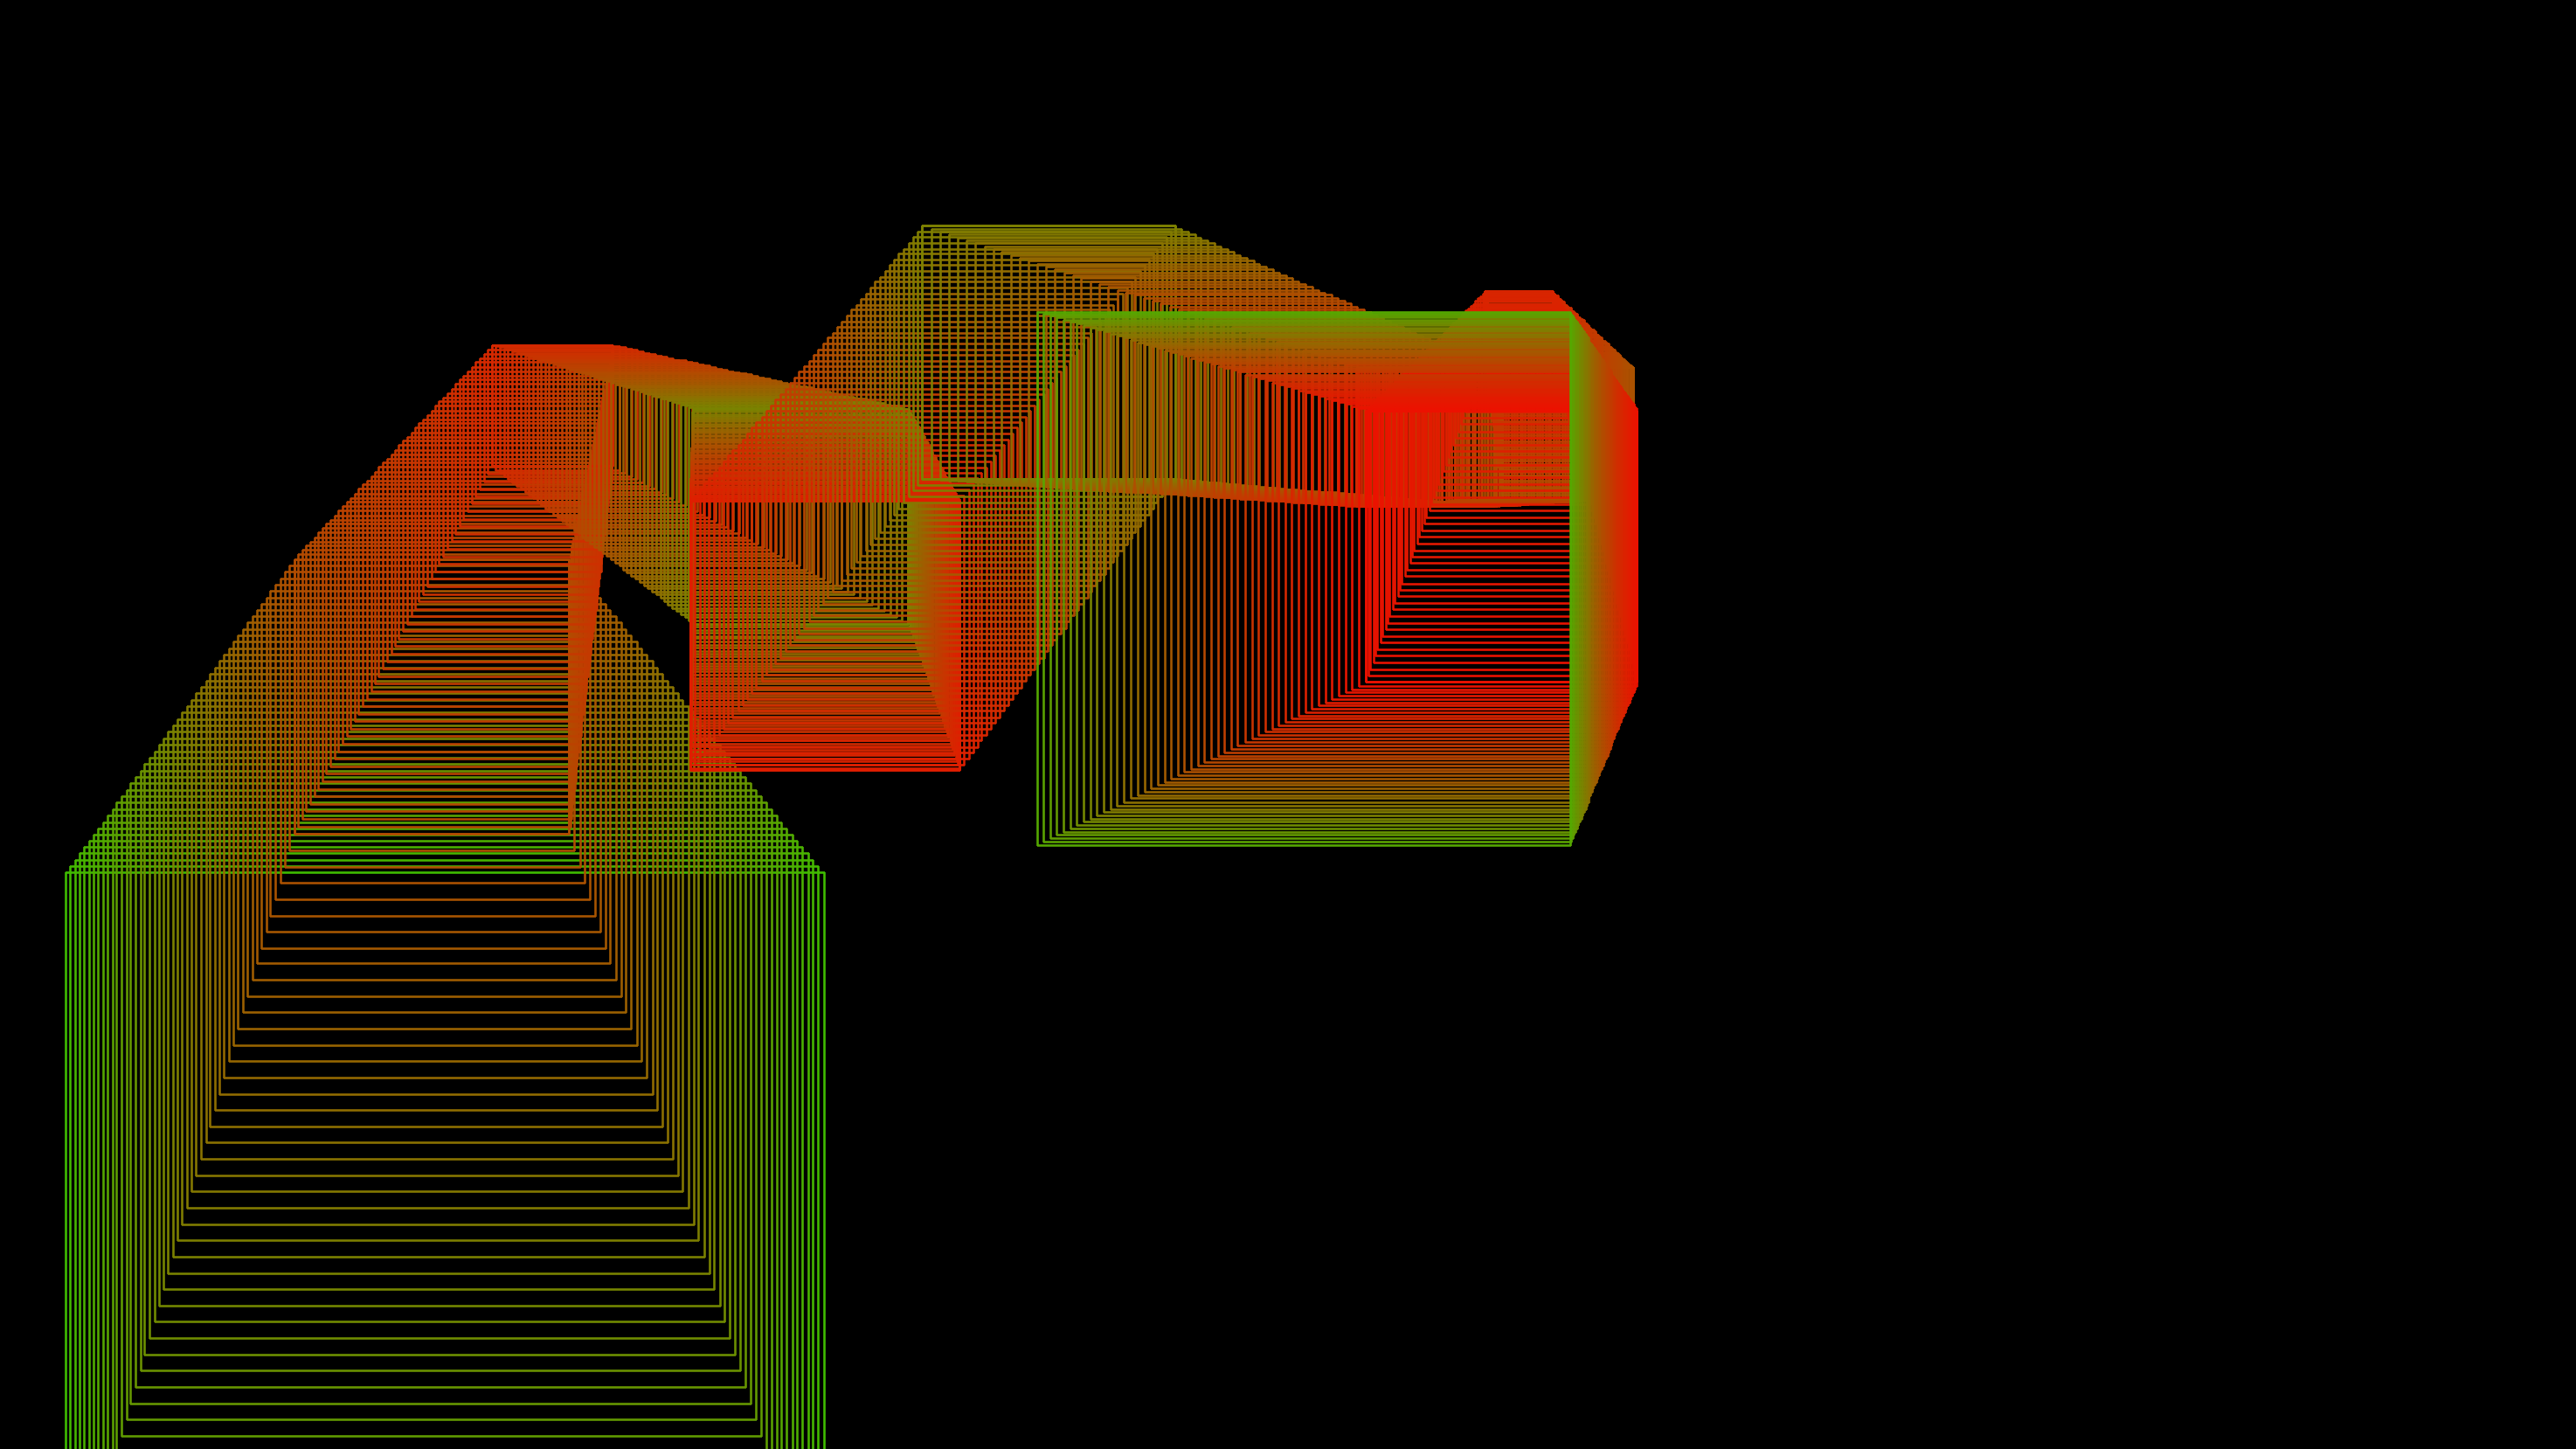

In [22]:
PIL.Image.fromarray(image2)

In [23]:
frames = []
for i in range(0,1):
    cur_frames = create_gif_full("new.gif",image,detections[i].final_box, detections[i+1].final_box, 50)
    frames.extend(cur_frames)
frames[0].save("new.gif", format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

# solve graph problem for normal connection
# other effects

In [24]:
image.shape

(1658, 2948, 3)

# not finished: 

In [25]:
def blend(c1, c2, alpha):
    r = (1-alpha)*c1[:, :, 0]   + alpha*c2[:, :, 0]
    g = (1-alpha)*c1[:, :, 1] + alpha*c2[:, :, 1]
    b = (1-alpha)*c1[:, :, 2]  + alpha*c2[:, :, 2]
    r, g, b =np.expand_dims(r, axis=2), np.expand_dims(g, axis=2), np.expand_dims(b, axis=2)
    c = np.concatenate((r, g, b), axis=2)
    c = c.astype(np.uint8)
    return c

def fade_frames(c1, c2, nb_interp=20):
    w, h = 400, 400
    c1 = c1.resize((w,h),PIL.Image.ANTIALIAS)
    c2 = c2.resize((w,h),PIL.Image.ANTIALIAS)
    frames = []
    for i in range(nb_interp+1):
        new_frame = PIL.Image.new('RGB', (w, h), 'white')
        im_cur = blend(np.array(c1), np.array(c2), i*1.0/nb_interp)
        im = PIL.Image.fromarray(im_cur)
        new_frame.paste(im, (0, 0))
        #new_frame = PIL.Image.fromarray(get_image(i,g_all), 'RGB')
        frames.append(new_frame)
    return frames



In [26]:
c1 = PIL.Image.fromarray(cropImage(image, detections[i].final_box))
c2 = PIL.Image.fromarray(cropImage(image, detections[i+1].final_box))
frames = fade_frames(c1, c2)
#frames.
frames[0].save('../fade.gif', format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

In [27]:
c3 = np.ones((int(detections[i].final_box.w),int(detections[i].final_box.h), 3))
c3 = c3.astype(np.uint8)
c3 = PIL.Image.fromarray(c3)
frames1 = fade_frames(c1, c3, 5)
frames2 = fade_frames(c3, c2, 5)
frames1.extend(frames2)
frames2 = fade_frames(c2, c3, 5)
frames1.extend(frames2)
frames2 = fade_frames(c3, c1, 5)
frames1.extend(frames2)
frames1[0].save('../fade1.gif', format='GIF', append_images=frames1[1:], save_all=True, duration=100, loop=0)